In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
df = pd.read_csv("../replication-materials-yuanninghuang-1/CECC/CES22_Common.csv")

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_64555/2776905057.py:1: DtypeWarning: Columns (359,360,363,364,613,614,617,618) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../replication-materials-yuanninghuang-1/CECC/CES22_Common.csv")


In [4]:
df.head()

,caseid,tookpost,commonweight,commonpostweight,CCEStake,add_confirm,inputzip,birthyr,gender4,gender4_t,...,page_CC22_441_grid_timing,page_CC22_443_timing,page_gunown_timing,page_numchildren_timing,page_edloan_timing,page_student_timing,starttime,endtime,starttime_post,endtime_post
0,1983126005,2,3.649671,3.525008,1,1.0,NaN,1992,1,__NA__,...,12.128,12.506,6.337,6.265,2.863,0.0,1.980030e+12,1.980030e+12,1.985230e+12,1.985230e+12
1,1983126559,2,0.780431,0.818539,1,NaN,1331.0,1957,1,__NA__,...,18.707,21.805,3.126,9.023,3.722,0.0,1.980030e+12,1.980030e+12,1.986030e+12,1.986030e+12
2,1983126197,2,0.891555,0.774314,1,1.0,NaN,1978,2,__NA__,...,6.448,4.443,2.105,3.108,3.622,0.0,1.980030e+12,1.980030e+12,1.984610e+12,1.984610e+12
3,1979974411,2,1.103598,1.207156,1,NaN,6716.0,1991,3,__NA__,...,11.287,10.843,5.421,4.947,3.000,0.0,1.980030e+12,1.980030e+12,1.984480e+12,1.984490e+12
4,1983130427,2,0.542923,0.327550,1,2.0,21401.0,1991,1,__NA__,...,12.222,19.317,3.458,3.843,4.173,0.0,1.980030e+12,1.980030e+12,1.985620e+12,1.985620e+12


In [5]:
# Create a new dataframe with 'caseid', 'voted', and 'senate_vote_choice' columns
new_df = df[['caseid']].copy()

# Create the 'voted' variable
new_df['voted'] = (df['CC22_401'] == 5).astype(int)

def get_senate_vote_choice(row):
    pre_vote = row['CC22_365_voted']
    post_vote = row['CC22_411']
    pre_state = row['inputstate']
    post_state = row['inputstate_post']

    def get_candidate_info(vote, suffix=''):
        if 1 <= vote <= 4:
            return row[f'SenCand{int(vote)}Name{suffix}'], row[f'SenCand{int(vote)}Party{suffix}']
        else:
            return None, None

    if pd.notna(pre_vote) and pd.notna(post_vote):
        if pre_vote == post_vote:
            name, party = get_candidate_info(post_vote, '_post')
            return post_vote, name, party, post_state
        else:
            return float('nan'), None, None, None  # set as missing if contradictory responses
    elif pd.notna(pre_vote):
        name, party = get_candidate_info(pre_vote)
        return pre_vote, name, party, pre_state
    elif pd.notna(post_vote):
        name, party = get_candidate_info(post_vote, '_post')
        return post_vote, name, party, post_state
    else:
        return float('nan'), None, None, None  # set as missing if both are missing

# Apply the updated function to the dataframe
new_df[['senate_vote_choice', 'senator_name', 'party', 'state']] = df.apply(get_senate_vote_choice, axis=1, result_type='expand')

#if voted for republican senator, party_voted is 0, if voted for democrats, party_voted is 1. Otherwise the value is -1
new_df['party_voted'] = new_df['party'].apply(lambda party: 1 if party == 'Democratic' else (0 if party == 'Republican' else (-1 if pd.isna(party) else 2)))
new_df = new_df.drop(columns=['party'])

new_df.head()


,caseid,voted,senate_vote_choice,senator_name,state,party_voted
0,1983126005,1,NaN,NaN,NaN,-1
1,1983126559,1,NaN,NaN,NaN,-1
2,1983126197,1,1.0,John Fetterman,42.0,1
3,1979974411,1,1.0,Richard Blumenthal,9.0,1
4,1983130427,0,NaN,NaN,NaN,-1


In [6]:
# Add the specified columns from 'df' to 'new_df'
control_vr = [ 'commonweight', 'commonpostweight','birthyr', 'gender4', 'educ', 'race', 'faminc_new', 'marstat', 'urbancity', 'region', 'presvote20post', 'presvote16post', \
    'pew_bornagain', 'pew_religimp', 'pew_churatd', 'pew_prayer', 'religpew', 'ideo5', 'CC22_320a', 'CC22_320g', 'CC22_320h', 'CurrentSen1Party', 'CurrentSen2Party',\
    'CC22_430a_8', 'CC22_310b', 'CC22_303', 'CC22_304']
important_vr = ['CC22_360', 'pid3', 'pid7', 'CC22_332a', 'CC22_332b', 'CC22_332c', 'CC22_332d', 'CC22_332e', 'CC22_332f', 'CC22_350d']
new_df = pd.concat([new_df, df[control_vr]], axis=1)
new_df = pd.concat([new_df, df[important_vr]], axis=1)

In [7]:
# Cleaning columns
new_df['age'] = 2022 - df['birthyr']
new_df = new_df.drop('birthyr', axis=1)

In [8]:
#if there is political involvement, give vaue 1, else 0
new_df['pol_involve'] = new_df['CC22_430a_8'].apply(lambda x: 0 if x > 6 else 1)
new_df = new_df.drop(columns=['CC22_430a_8'])

#Calculate approval for senators in different political parties
recode_map = {1: 2, 2: 1, 5: 0, 3: -1, 4: -2}
new_df['CC22_320g'] = new_df['CC22_320g'].map(recode_map)
df['CC22_320h'] = df['CC22_320h'].map(recode_map)

# Define a function to calculate the average rating for a given party
def get_party_attitude(row, party):
    ratings = []
    if row['CurrentSen1Party'] == party:
        ratings.append(row['CC22_320g'])
    if row['CurrentSen2Party'] == party:
        ratings.append(row['CC22_320h'])
    
    return sum(ratings) / len(ratings) if ratings else None

# Create new columns 'attitude_towards_party' as the average rating for each party
new_df['attitude_towards_dem'] = new_df.apply(lambda row: get_party_attitude(row, 'Democratic'), axis=1)
new_df['attitude_towards_rep'] = new_df.apply(lambda row: get_party_attitude(row, 'Republican'), axis=1)

# Drop the original columns
new_df = new_df.drop(columns=['CC22_320g', 'CC22_320h', 'CurrentSen1Party', 'CurrentSen2Party'])

In [9]:
column_mapping = {'senator_name': 'senator_voted', 'gender4':'gender', 'faminc_new': 'fam_income',\
    'ideo5': 'pol_ideo', 'CC22_320a': 'approval_biden', 'CC22_310b': 'know_senate', 'CC22_303': 'income_change', 'CC22_304': 'price_change',\
    'CC22_360': 'party_registered', 'pid3': 'party_identified', 'pid7': 'party_strength', 'CC22_332a':'abortion_all_cases', 'CC22_332b':'abortion_some_cases', \
    'CC22_332c': 'abortion_before_20weeks', 'CC22_332d': 'abortion_coverage', 'CC22_332e': 'abortion_funds', 'CC22_332f': 'abortion_illegal', 'CC22_350d': 'congress_abortion'}

new_df = new_df.rename(columns=column_mapping)

#cast column type
nonint_col = ['senator_voted', 'party_voted', 'commonweight', 'commonpostweight', 'attitude_towards_dem', 'attitude_towards_rep']
for i in new_df.columns.to_list():
    if i not in nonint_col:
        new_df[i].fillna(-1, inplace=True)
        new_df[i] = new_df[i].astype(int)

In [38]:
#create column for states with abortion on ballot
#source: https://ballotpedia.org/2022_abortion-related_ballot_measures
abortion_states = [6, 21, 26, 30, 50]
new_df['abortion_ballot'] = new_df['state'].apply(lambda row: 1 if row in abortion_states else 0)

In [39]:
new_df

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_before_20weeks,abortion_coverage,abortion_funds,abortion_illegal,congress_abortion,age,pol_involve,attitude_towards_dem,attitude_towards_rep,abortion_ballot
0,1983126005,1,-1,NaN,-1,-1,3.649671,3.525008,1,6,...,2,2,2,2,1,30,1,1.5,NaN,0
1,1983126559,1,-1,NaN,-1,-1,0.780431,0.818539,1,3,...,2,2,1,2,1,65,1,1.0,NaN,0
2,1983126197,1,1,John Fetterman,42,1,0.891555,0.774314,2,5,...,2,2,2,2,1,44,1,0.0,5.0,0
3,1979974411,1,1,Richard Blumenthal,9,1,1.103598,1.207156,3,6,...,2,2,2,2,1,31,1,1.0,NaN,0
4,1983130427,0,-1,NaN,-1,-1,0.542923,0.327550,1,6,...,1,2,2,2,1,31,1,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2045974583,0,-1,NaN,-1,-1,0.255190,NaN,2,2,...,2,1,2,2,2,37,1,NaN,2.5,0
59996,2045981019,0,-1,NaN,-1,-1,1.478491,0.930118,2,4,...,2,2,2,2,1,26,1,NaN,2.5,0
59997,2045852523,0,-1,NaN,-1,-1,0.195928,NaN,1,2,...,2,2,2,2,2,33,1,1.0,2.0,0
59998,2045338427,1,1,Chuck Schumer,36,1,1.167724,1.256827,1,6,...,1,1,1,2,1,32,1,1.5,NaN,0


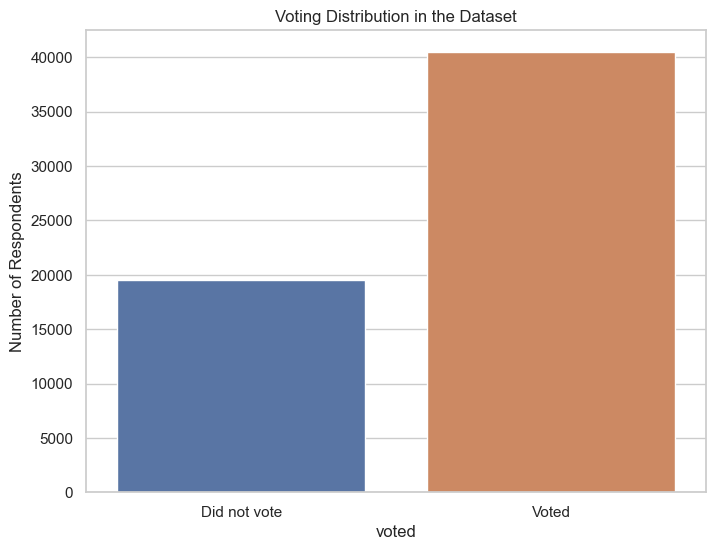

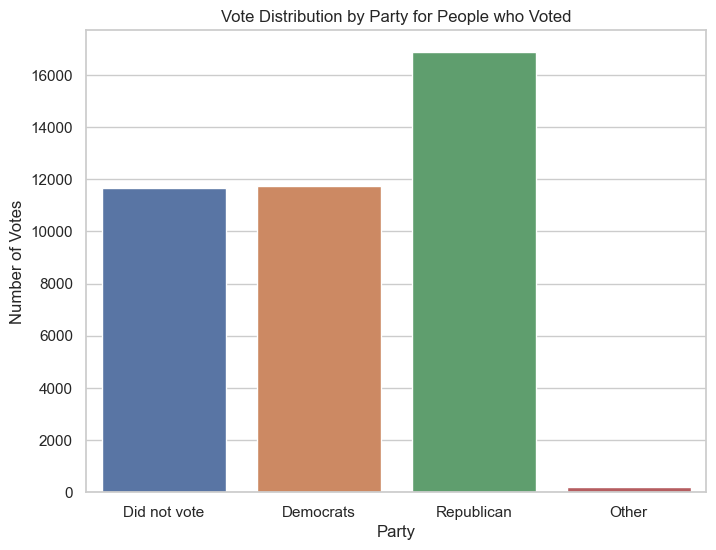

In [12]:
# Set the style for the plots
sns.set(style='whitegrid')

# Plot the distribution of how many people voted in the dataset
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df, x='voted')
ax.set_xticklabels(['Did not vote', 'Voted'])
ax.set_title('Voting Distribution in the Dataset')
ax.set_ylabel('Number of Respondents')
plt.show()

# Plot the distribution of people who voted for each party
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df[new_df['voted'] == 1], x='party_voted')
ax.set_xticklabels(['Did not vote', 'Democrats', 'Republican', 'Other'])
ax.set_title('Vote Distribution by Party for People who Voted')
ax.set_xlabel('Party')
ax.set_ylabel('Number of Votes')
plt.show()


In [13]:
# Function to extract the social and economic scores from the website
def extract_scores(candidate_website):
    # Request the candidate's website
    response = requests.get(candidate_website)
    
    # Parse the website's HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the "Click for details" hyperlink
    details_link = soup.find('a', href=re.compile(r'^https://www.OnTheIssues.org/VoteMatch/candidate_map.asp'))
    
    if details_link is None:
        return -1, -1
    
    # Follow the "Click for details" hyperlink
    url = details_link['href']
    response = requests.get(url)

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the social and economic scores in the HTML
    all_tr = soup.find_all("tr")

    # Extract the social and economic scores
    social_score = all_tr[5].find_all("td")[1].find("font").text.strip("%")
    economic_score = all_tr[6].find_all("td")[1].find("font").text.strip("%")

    return social_score, economic_score

#function that stores the scores in the dataframe
def store_scores(df):
    for i, row in df.iterrows():
        name = row['senator']
        if name == 'J.D. Vance':
            str = 'JD_Vance'
        elif name == 'Thomas McDermott Jr.':
            str = 'Thomas_McDermott'
        elif name == 'Todd C. Young':
            str = 'Todd_Young'
        elif name == "Joe O'Dea":
            str = 'Joe_O%60Dea'
        elif name == 'John Kennedy':
            str = 'John_Neely_Kennedy'
        elif name == 'Mark R. Holland':
            str = 'Mark_Holland'
        else:
            str = "_".join(name.split())
        
        url = "https://www.ontheissues.org/Senate/" + str + '.htm' 
        social_score, economic_score = extract_scores(url)
        df.at[i, 'social_score'] = social_score
        df.at[i, 'economic_score'] = economic_score

In [14]:
#create a dataframe to store candidate information
candidate_df = new_df[['senator_voted', 'state', 'party_voted']].groupby('senator_voted').first().reset_index()
candidate_df.columns = ['senator', 'state', 'party']

#import candidates endorsed by trump
trump_endorsement = pd.read_csv('trump_endorsement.csv', skiprows=1, header=None)
trump_endorsement.columns = ['endorsed_senator']

#create new column about trump endorsement
candidate_df['trump_endorsement'] = candidate_df['senator'].isin(trump_endorsement['endorsed_senator']).astype(int)

#create new columns the store the scores of each candidate
store_scores(candidate_df)

In [15]:
candidate_df

,senator,state,party,trump_endorsement,social_score,economic_score
0,Adam Laxalt,32,0,1,28,83
1,Alex Padilla,6,1,0,83,25
2,Blake Masters,4,0,1,25,80
3,Bob McDermott,15,0,0,30,63
4,Brian Bengs,46,1,0,43,30
...,...,...,...,...,...,...
69,Todd C. Young,18,0,0,35,85
70,Tommy Williams,49,2,0,-1,-1
71,Trudy Busch Valentine,29,1,0,53,15
72,Val Demings,12,1,0,83,15


In [40]:
# Select only the required columns for aggregation
agg_columns = candidate_df[['state', 'party', 'social_score', 'economic_score', 'trump_endorsement']]

# Convert 'social_score' and 'economic_score' to numeric data types
candidate_df['social_score'] = pd.to_numeric(candidate_df['social_score'], errors='coerce')
candidate_df['economic_score'] = pd.to_numeric(candidate_df['economic_score'], errors='coerce')

# Group by 'state' and 'party' and calculate the mean 'social_score', 'economic_score', and 'trump_endorsement' for each group
state_level_agg = candidate_df.groupby(['state', 'party']).agg({
    'social_score': 'mean',
    'economic_score': 'mean',
    'trump_endorsement': lambda x: x.astype(int).mean()
}).reset_index()

# Merge
merged_df = new_df.merge(state_level_agg, how='left', left_on=['state', 'party_voted'], right_on=['state', 'party'])

# Drop the 'party' column since it is not needed anymore
merged_df.drop('party', axis=1, inplace=True)

#filter out people who did not vote or their votes were not recorded
merged_df = merged_df[(merged_df['voted'] != 0) & (merged_df['senate_vote_choice'] != -1) & (merged_df['senator_voted'].notnull())]

# Display the updated dataframe
merged_df


,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_illegal,congress_abortion,age,pol_involve,attitude_towards_dem,attitude_towards_rep,abortion_ballot,social_score,economic_score,trump_endorsement
2,1983126197,1,1,John Fetterman,42,1,0.891555,0.774314,2,5,...,2,1,44,1,0.0,5.0,0,80.0,25.0,0.0
3,1979974411,1,1,Richard Blumenthal,9,1,1.103598,1.207156,3,6,...,2,1,31,1,1.0,NaN,0,65.0,15.0,0.0
5,1981687607,1,2,Don Bolduc,33,0,0.114487,0.098909,1,5,...,2,2,67,1,1.0,NaN,0,33.0,73.0,1.0
6,1983125989,1,1,Raphael Warnock,13,1,0.899045,1.210827,2,2,...,2,2,54,1,0.5,NaN,0,68.0,15.0,0.0
8,1981900613,1,1,John Fetterman,42,1,0.900071,0.853897,2,5,...,2,1,75,1,-1.0,3.0,0,80.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59983,2046109403,1,2,Ted Budd,37,0,1.504072,1.469039,2,2,...,1,1,29,1,NaN,2.5,0,20.0,90.0,1.0
59991,2046109215,1,1,Alex Padilla,6,1,1.058854,0.826751,2,6,...,1,1,35,1,2.0,NaN,1,83.0,25.0,0.0
59993,2046149923,1,1,Chuck Schumer,36,1,0.949129,0.814437,2,6,...,2,1,31,1,3.0,NaN,0,70.0,5.0,0.0
59998,2045338427,1,1,Chuck Schumer,36,1,1.167724,1.256827,1,6,...,2,1,32,1,1.5,NaN,0,70.0,5.0,0.0


In [31]:
#combine attitudes towards dem and attitudes towards rep
def combine_attitudes(row):
    attitudes = [row['attitude_towards_dem'], row['attitude_towards_rep']]
    valid_attitudes = [att for att in attitudes if pd.notnull(att)]
    return sum(valid_attitudes) / len(valid_attitudes) if valid_attitudes else None

merged_df['attitude_towards_current_senators'] = merged_df.apply(combine_attitudes, axis=1)
merged_df = merged_df.drop(columns=['attitude_towards_rep', 'attitude_towards_dem'])

In [41]:
#check for missing value
missing_values_count = merged_df.isnull().sum()
print(missing_values_count)

caseid                         0
voted                          0
senate_vote_choice             0
senator_voted                  0
state                          0
party_voted                    0
commonweight                   0
commonpostweight               0
gender                         0
educ                           0
race                           0
fam_income                     0
marstat                        0
urbancity                      0
region                         0
presvote20post                 0
presvote16post                 0
pew_bornagain                  0
pew_religimp                   0
pew_churatd                    0
pew_prayer                     0
religpew                       0
pol_ideo                       0
approval_biden                 0
know_senate                    0
income_change                  0
price_change                   0
party_registered               0
party_identified               0
party_strength                 0
abortion_a

In [42]:
#For remaining rows without attitudes_towards_current_senators values, fill them with mean
merged_df.fillna(merged_df.mean(), inplace=True)

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_64555/1359032956.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_df.fillna(merged_df.mean(), inplace=True)


In [34]:
#check for missing value
missing_values_count = merged_df.isnull().sum()
print(missing_values_count)

caseid                               0
voted                                0
senate_vote_choice                   0
senator_voted                        0
state                                0
party_voted                          0
commonweight                         0
commonpostweight                     0
gender                               0
educ                                 0
race                                 0
fam_income                           0
marstat                              0
urbancity                            0
region                               0
presvote20post                       0
presvote16post                       0
pew_bornagain                        0
pew_religimp                         0
pew_churatd                          0
pew_prayer                           0
religpew                             0
pol_ideo                             0
approval_biden                       0
know_senate                          0
income_change            

In [43]:
print(merged_df['pol_involve'].value_counts())
merged_df = merged_df.drop(columns=['pol_involve'])

1    28820
Name: pol_involve, dtype: int64


In [44]:
#Construct list of control variable names, independent variable name, and dependent variable name
X_var = ['abortion_ballot']
Y_var = ['party_voted']
Z_var = [z for z in merged_df.columns.to_list() if z not in ['abortion_ballot', 'party_voted', 'commonweight', 'commonpostweight', 'caseid', 'voted', 'state', 'senator_voted', 'senate_vote_choice']]

#Check if control variables have significant relationship with the independent variable
X = merged_df[X_var]
Z = merged_df[Z_var]

# Add a constant to the independent variables
Z = sm.add_constant(Z)

# Perform logistic regression
logit_model = sm.Logit(X, Z)
logit_result = logit_model.fit()

# Print the results
# 17 variables are significant
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.177115
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:        abortion_ballot   No. Observations:                28820
Model:                          Logit   Df Residuals:                    28784
Method:                           MLE   Df Model:                           35
Date:                Sun, 30 Apr 2023   Pseudo R-squ.:                  0.5530
Time:                        16:05:43   Log-Likelihood:                -5104.4
converged:                       True   LL-Null:                       -11420.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -22.0143      0.527    -41.769      0.000     -23.047  

In [26]:
# Prepare the feature set (X) and the treatment indicator (W)
Z = merged_df[Z_var]
X = merged_df[X_var]

# Estimate propensity scores using logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(Z, X)
merged_df['propensity_score'] = lr.predict_proba(Z)[:, 1]

# Split treated and control observations
treated = merged_df[merged_df['abortion_ballot'] == 1]
control = merged_df[merged_df['abortion_ballot'] == 0]

# Match treated and control observations based on propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
indices = indices.reshape(-1)

# Create a matched dataset
matched_control = control.iloc[indices]
matched_treated = treated.reset_index(drop=True)

# Concatenate matched treated and control observations
matched_data = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)


#what if there's a tie
#are you matching on the treatment or control group? there's a difference
#average treatment effect for the treated: start with the treated and match on control. What would happen to them if they are not treated
#average treatment effect for the non-treated: start with the control and match on treated. What would happen to them if they are treated
#       eg. what if illinois have abortion on ballot

#in my case, I should go for average treatment effect for the treated. because all people in the 5 states can have a match
#intepretation: what would happen if california does not have abortion on ballot?

#if someone is dropped because they can't be matched to other people, then it would make my sample not representative
#argue that I am only giving a rough estimate of the effect size, but then weighting may not even matter that match
#usually matching does not dramtically change results


/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
# Set a caliper value, maximum allowable distance
caliper = 0.05

# Prepare the feature set (Z) and the treatment indicator (W)
Z = merged_df[Z_var]
X = merged_df[X_var]

# Estimate propensity scores using logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(Z, X)
merged_df['propensity_score'] = lr.predict_proba(Z)[:, 1]

# Split treated and control observations
treated = merged_df[merged_df['abortion_ballot'] == 1]
control = merged_df[merged_df['abortion_ballot'] == 0]

# Match treated and control observations based on propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
indices = indices.reshape(-1)

# Create a matched dataset
matched_control_indices = []
matched_treated_indices = []
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if dist <= caliper:
        matched_control_indices.append(idx)
        matched_treated_indices.append(i)

matched_control = control.iloc[matched_control_indices]
matched_treated = treated.iloc[matched_treated_indices]

# Concatenate matched treated and control observations
matched_data = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)


/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
matched_data

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_funds,abortion_illegal,congress_abortion,age,abortion_ballot,social_score,economic_score,trump_endorsement,attitude_towards_current_senators,propensity_score
0,1983126033,1,2,Mark Meuser,6,0,1.226313,0.997712,1,6,...,1,1,2,37,1,18.0,73.0,0.0,2.0,0.207645
1,1983202389,1,1,Alex Padilla,6,1,0.905339,0.710053,2,5,...,2,2,1,34,1,83.0,25.0,0.0,2.0,0.776030
2,1982290075,1,1,Alex Padilla,6,1,0.671453,0.433286,1,1,...,2,2,1,66,1,83.0,25.0,0.0,1.5,0.756623
3,1981978265,1,2,Rand Paul,21,0,0.993021,0.850214,1,3,...,1,2,2,69,1,63.0,88.0,1.0,0.0,0.550259
4,1983209009,1,2,Mark Meuser,6,0,0.935423,0.806969,2,3,...,1,2,1,70,1,18.0,73.0,0.0,1.0,0.520227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7791,2036448291,1,2,Joe O'Dea,8,0,1.407304,1.342628,1,5,...,2,2,1,62,0,33.0,83.0,0.0,1.5,0.856263
7792,1999870445,1,1,Ron Wyden,41,1,0.495260,0.430637,1,3,...,2,2,1,76,0,80.0,13.0,0.0,1.5,0.293084
7793,2010880581,1,1,Brian Schatz,15,1,1.101269,1.388941,1,3,...,2,2,2,39,0,90.0,35.0,0.0,2.0,0.821033
7794,2011359359,1,2,Joe O'Dea,8,0,1.809119,1.340606,2,6,...,1,1,2,56,0,33.0,83.0,0.0,2.5,0.806851


In [25]:
#Check if control variables have significant relationship with the independent variable
X = matched_data[X_var]
Z = matched_data[Z_var]

# Add a constant to the independent variables
Z = sm.add_constant(Z)

# Perform logistic regression
logit_model = sm.Logit(X, Z)
logit_result = logit_model.fit()

# Print the results
# 19 variables are significant
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.586525
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        abortion_ballot   No. Observations:                 7796
Model:                          Logit   Df Residuals:                     7761
Method:                           MLE   Df Model:                           34
Date:                Sun, 30 Apr 2023   Pseudo R-squ.:                  0.1538
Time:                        14:33:04   Log-Likelihood:                -4572.6
converged:                       True   LL-Null:                       -5403.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 1.7697      0.560      3

#calculate the mean of the difference, show whether it's 0. run a t-test to see if the mean of difference is 0
#propensity score matching: match individuals that have the same probability to receive treatment in the treatment group to the control group
#propensity score matching makes sure the control variables are not causing the independent variable, so there's no spurious correlation that X causes Y is because Z causes X and Z causes Y

#before matching, surley there's correlation between X and Z; after matching, there should not be any correlation between X and Z
#just need one row of the heatmap, between X and all the Z
#or do another logistical regression to see if there's any significance between X and Zs (shouldn't be there after matching)!!
# 

In [ ]:
#singular matrix error: one of the variable I use is the linear combination of other variables
#if I can calculate the propensity score before matching, that means I should be able to run it after matching
# see the diffeence between the Y of two groups, run a t-test

#weights only matter if I want to translate it into a formula: eg. ballot causes 2% of the margin > some people care baout the effect size because if population is large, everything can be significant
#if only want to see if there's significance, don't need the weights

#when running analysis, run a weigted t-test, multiply the independent variable by the weight

In [371]:
# Create a formula string for the t-test
party_voted = matched_data[Y_var]
abortion_on_ballot = matched_data[X_var]

formula = 'party_voted ~ abortion_on_ballot'
if Z_var:
    formula += ' + ' + ' + '.join(Z_var)

# Conduct the t-test
model = smf.ols(formula, data=matched_data).fit()

# Print the summary of the results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            party_voted   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     6458.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:26:48   Log-Likelihood:                 7699.3
No. Observations:                7796   AIC:                        -1.533e+04
Df Residuals:                    7760   BIC:                        -1.508e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [45]:
## Now we want to treat states that have abortion on ballot differently depending on the type of ballot question
protect_abortion_states = [6, 26, 50]
against_abortion_states = [21, 30]
new_df['abortion_ballot'] = new_df['state'].apply(lambda row: 2 if row in protect_abortion_states else (1 if row in against_abortion_states else 0))

In [46]:
# Select only the required columns for aggregation
agg_columns = candidate_df[['state', 'party', 'social_score', 'economic_score', 'trump_endorsement']]

# Convert 'social_score' and 'economic_score' to numeric data types
candidate_df['social_score'] = pd.to_numeric(candidate_df['social_score'], errors='coerce')
candidate_df['economic_score'] = pd.to_numeric(candidate_df['economic_score'], errors='coerce')

# Group by 'state' and 'party' and calculate the mean 'social_score', 'economic_score', and 'trump_endorsement' for each group
state_level_agg = candidate_df.groupby(['state', 'party']).agg({
    'social_score': 'mean',
    'economic_score': 'mean',
    'trump_endorsement': lambda x: x.astype(int).mean()
}).reset_index()

# Merge
merged_df = new_df.merge(state_level_agg, how='left', left_on=['state', 'party_voted'], right_on=['state', 'party'])

# Drop the 'party' column since it is not needed anymore
merged_df.drop('party', axis=1, inplace=True)

#filter out people who did not vote or their votes were not recorded
merged_df = merged_df[(merged_df['voted'] != 0) & (merged_df['senate_vote_choice'] != -1) & (merged_df['senator_voted'].notnull())]

# Display the updated dataframe
merged_df

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_illegal,congress_abortion,age,pol_involve,attitude_towards_dem,attitude_towards_rep,abortion_ballot,social_score,economic_score,trump_endorsement
2,1983126197,1,1,John Fetterman,42,1,0.891555,0.774314,2,5,...,2,1,44,1,0.0,5.0,0,80.0,25.0,0.0
3,1979974411,1,1,Richard Blumenthal,9,1,1.103598,1.207156,3,6,...,2,1,31,1,1.0,NaN,0,65.0,15.0,0.0
5,1981687607,1,2,Don Bolduc,33,0,0.114487,0.098909,1,5,...,2,2,67,1,1.0,NaN,0,33.0,73.0,1.0
6,1983125989,1,1,Raphael Warnock,13,1,0.899045,1.210827,2,2,...,2,2,54,1,0.5,NaN,0,68.0,15.0,0.0
8,1981900613,1,1,John Fetterman,42,1,0.900071,0.853897,2,5,...,2,1,75,1,-1.0,3.0,0,80.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59983,2046109403,1,2,Ted Budd,37,0,1.504072,1.469039,2,2,...,1,1,29,1,NaN,2.5,0,20.0,90.0,1.0
59991,2046109215,1,1,Alex Padilla,6,1,1.058854,0.826751,2,6,...,1,1,35,1,2.0,NaN,2,83.0,25.0,0.0
59993,2046149923,1,1,Chuck Schumer,36,1,0.949129,0.814437,2,6,...,2,1,31,1,3.0,NaN,0,70.0,5.0,0.0
59998,2045338427,1,1,Chuck Schumer,36,1,1.167724,1.256827,1,6,...,2,1,32,1,1.5,NaN,0,70.0,5.0,0.0


In [47]:
merged_df['attitude_towards_current_senators'] = merged_df.apply(combine_attitudes, axis=1)
merged_df = merged_df.drop(columns=['attitude_towards_rep', 'attitude_towards_dem'])

merged_df.fillna(merged_df.mean(), inplace=True)

merged_df = merged_df.drop(columns=['pol_involve'])

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_64555/1784009465.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_df.fillna(merged_df.mean(), inplace=True)


In [54]:
# Compare only states that have ballot questions supporting abortion rights to states without abortion ballot questions
merged_df_for = merged_df[merged_df['abortion_ballot'].isin([0,2])]
merged_df_for['abortion_ballot'] = merged_df_for['abortion_ballot'].replace(2, 1)

# Compare only states that have ballot questions prohibiting abortion rights to states without abortion ballot questions
merged_df_against = merged_df[merged_df['abortion_ballot'].isin([0,1])]

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_64555/4214156814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_for['abortion_ballot'] = merged_df_for['abortion_ballot'].replace(2, 1)


In [56]:
#Construct list of control variable names, independent variable name, and dependent variable name
X_var = ['abortion_ballot']
Y_var = ['party_voted']
Z_var = [z for z in merged_df.columns.to_list() if z not in ['abortion_ballot', 'party_voted', 'commonweight', 'commonpostweight', 'caseid', 'voted', 'state', 'senator_voted', 'senate_vote_choice']]

#Check if control variables have significant relationship with the independent variable
X = merged_df_for[X_var]
Z = merged_df_for[Z_var]

# Add a constant to the independent variables
Z = sm.add_constant(Z)

# Perform logistic regression
logit_model = sm.Logit(X, Z)
logit_result = logit_model.fit()

# Print the results
# 17 variables are significant
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.153852
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:        abortion_ballot   No. Observations:                28250
Model:                          Logit   Df Residuals:                    28215
Method:                           MLE   Df Model:                           34
Date:                Sun, 30 Apr 2023   Pseudo R-squ.:                  0.5756
Time:                        16:23:45   Log-Likelihood:                -4346.3
converged:                       True   LL-Null:                       -10241.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               -21.4478      0.594    -3

In [58]:
merged_df_for['abortion_ballot'].value_counts()

0    24922
1     3328
Name: abortion_ballot, dtype: int64

In [60]:
# Set a caliper value, maximum allowable distance
caliper = 0.05

# Prepare the feature set (Z) and the treatment indicator (W)
Z = merged_df_for[Z_var]
X = merged_df_for[X_var]

# Estimate propensity scores using logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(Z, X)
merged_df_for['propensity_score'] = lr.predict_proba(Z)[:, 1]

# Split treated and control observations
treated = merged_df_for[merged_df_for['abortion_ballot'] == 1]
control = merged_df_for[merged_df_for['abortion_ballot'] == 0]

# Match treated and control observations based on propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
indices = indices.reshape(-1)

# Create a matched dataset
matched_control_indices = []
matched_treated_indices = []
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if dist <= caliper:
        matched_control_indices.append(idx)
        matched_treated_indices.append(i)

matched_control = control.iloc[matched_control_indices]
matched_treated = treated.iloc[matched_treated_indices]

# Concatenate matched treated and control observations
matched_data_for = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)

/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_64555/3221609834.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [61]:
#Check if control variables have significant relationship with the independent variable
X = matched_data_for[X_var]
Z = matched_data_for[Z_var]

# Add a constant to the independent variables
Z = sm.add_constant(Z)

# Perform logistic regression
logit_model = sm.Logit(X, Z)
logit_result = logit_model.fit()

# Print the results
# 19 variables are significant
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.583536
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        abortion_ballot   No. Observations:                 6656
Model:                          Logit   Df Residuals:                     6621
Method:                           MLE   Df Model:                           34
Date:                Sun, 30 Apr 2023   Pseudo R-squ.:                  0.1581
Time:                        16:26:58   Log-Likelihood:                -3884.0
converged:                       True   LL-Null:                       -4613.6
Covariance Type:            nonrobust   LLR p-value:                4.446e-285
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 8.0191      0.683     11

In [62]:
# Create a formula string for the t-test
party_voted = matched_data_for[Y_var]
abortion_on_ballot = matched_data_for[X_var]

formula = 'party_voted ~ abortion_on_ballot'
if Z_var:
    formula += ' + ' + ' + '.join(Z_var)

# Conduct the t-test
model = smf.ols(formula, data=matched_data_for).fit()

# Print the summary of the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            party_voted   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     7102.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:28:17   Log-Likelihood:                 7382.9
No. Observations:                6656   AIC:                        -1.469e+04
Df Residuals:                    6620   BIC:                        -1.445e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [63]:
#Construct list of control variable names, independent variable name, and dependent variable name
X_var = ['abortion_ballot']
Y_var = ['party_voted']
Z_var = [z for z in merged_df.columns.to_list() if z not in ['abortion_ballot', 'party_voted', 'commonweight', 'commonpostweight', 'caseid', 'voted', 'state', 'senator_voted', 'senate_vote_choice']]

#Check if control variables have significant relationship with the independent variable
X = merged_df_against[X_var]
Z = merged_df_against[Z_var]

# Add a constant to the independent variables
Z = sm.add_constant(Z)

# Perform logistic regression
logit_model = sm.Logit(X, Z)
logit_result = logit_model.fit()

# Print the results
# 17 variables are significant
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.028644
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:        abortion_ballot   No. Observations:                25492
Model:                          Logit   Df Residuals:                    25457
Method:                           MLE   Df Model:                           34
Date:                Sun, 30 Apr 2023   Pseudo R-squ.:                  0.7325
Time:                        16:30:45   Log-Likelihood:                -730.19
converged:                       True   LL-Null:                       -2729.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               -52.6117      2.950    -1

In [65]:
# Set a caliper value, maximum allowable distance
caliper = 0.05

# Prepare the feature set (Z) and the treatment indicator (W)
Z = merged_df_against[Z_var]
X = merged_df_against[X_var]

# Estimate propensity scores using logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(Z, X)
merged_df_against['propensity_score'] = lr.predict_proba(Z)[:, 1]

# Split treated and control observations
treated = merged_df_against[merged_df_against['abortion_ballot'] == 1]
control = merged_df_against[merged_df_against['abortion_ballot'] == 0]

# Match treated and control observations based on propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
indices = indices.reshape(-1)

# Create a matched dataset
matched_control_indices = []
matched_treated_indices = []
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if dist <= caliper:
        matched_control_indices.append(idx)
        matched_treated_indices.append(i)

matched_control = control.iloc[matched_control_indices]
matched_treated = treated.iloc[matched_treated_indices]

# Concatenate matched treated and control observations
matched_data_against = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)

/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_64555/1063536727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [66]:
#Check if control variables have significant relationship with the independent variable
X = matched_data_against[X_var]
Z = matched_data_against[Z_var]

# Add a constant to the independent variables
Z = sm.add_constant(Z)

# Perform logistic regression
logit_model = sm.Logit(X, Z)
logit_result = logit_model.fit()

# Print the results
# 19 variables are significant
print(logit_result.summary())

/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [67]:
# Create a formula string for the t-test
party_voted = matched_data_against[Y_var]
abortion_on_ballot = matched_data_against[X_var]

formula = 'party_voted ~ abortion_on_ballot'
if Z_var:
    formula += ' + ' + ' + '.join(Z_var)

# Conduct the t-test
model = smf.ols(formula, data=matched_data_against).fit()

# Print the summary of the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            party_voted   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.092e+28
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:38:43   Log-Likelihood:                 19023.
No. Observations:                 590   AIC:                        -3.797e+04
Df Residuals:                     554   BIC:                        -3.782e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [68]:
matched_data_against

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_funds,abortion_illegal,congress_abortion,age,abortion_ballot,social_score,economic_score,trump_endorsement,attitude_towards_current_senators,propensity_score
0,1984207075,1,1,Charles Booker,21,1,0.409432,0.288727,2,5,...,2,2,1,23,1,85.0,18.0,0.0,1.5,0.066541
1,1984211471,1,1,Charles Booker,21,1,0.386925,0.314139,2,6,...,2,2,1,46,1,85.0,18.0,0.0,1.0,0.224628
2,1983932365,1,1,Charles Booker,21,1,0.425903,0.406279,2,3,...,2,2,1,43,1,85.0,18.0,0.0,0.5,0.573010
3,1984021175,1,1,Charles Booker,21,1,0.485971,0.344207,1,5,...,2,2,1,46,1,85.0,18.0,0.0,0.5,0.541839
4,1984266533,1,1,Charles Booker,21,1,0.427761,0.351797,1,5,...,2,2,1,71,1,85.0,18.0,0.0,1.0,0.232561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,2014888097,1,1,Val Demings,12,1,0.552376,0.521016,2,3,...,2,2,1,64,0,83.0,15.0,0.0,0.0,0.387520
586,2009031643,1,1,Chris Van Hollen,24,1,0.602012,0.640397,2,3,...,2,2,1,37,0,88.0,15.0,0.0,0.5,0.615928
587,1995753365,1,1,Val Demings,12,1,1.595834,1.812667,1,5,...,2,2,1,28,0,83.0,15.0,0.0,0.5,0.119807
588,1998595409,1,1,Chris Van Hollen,24,1,1.166112,1.132163,2,4,...,2,2,1,41,0,88.0,15.0,0.0,1.5,0.245853
